In [3]:
!pip install eli5
!pip install wordcloud
!pip install nltk
!pip install --upgrade plotly 
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from plotly import tools
from plotly import subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import eli5
sns.set()

     |████████████████████████████████| 7.2MB 2.7MB/s eta 0:00:01
  Found existing installation: plotly 4.1.0
    Uninstalling plotly-4.1.0:
      Successfully uninstalled plotly-4.1.0


[nltk_data] Downloading package stopwords to
[nltk_data]     /notebooks/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Wrangling

In [8]:
train_df = pd.read_csv('../data/sarcasm/train-balanced-sarcasm.csv')


In [25]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-

## Removing missing data

In [14]:
train_df.dropna(subset=['comment'], inplace=True)
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

## Porter Stemming 

In [15]:
stop = stopwords.words('english')
train_df['processedtext'] = train_df['comment'].str.replace('[^\w\s]','') 
train_df['processedtext'] = train_df['processedtext'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train_df['processedtext'] = train_df['processedtext'].apply(lambda x: " ".join(x.lower() for x in x.split()))

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
train_df['processedtext'] = train_df['processedtext'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

In [17]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,processedtext
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",nc nh
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,you know west team play west team east team right
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,they underdog earlier today sinc gronk announc...
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,thi meme isnt funni none new york nigga one
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,i could use one tool


In [18]:
text_train, text_test, y_train, y_test = \
        train_test_split(train_df['processedtext'], train_df['label'], random_state=17)

In [19]:
print("Train shape: ", text_train.shape[0])
print("Test shape: ", text_test.shape[0])

Train shape:  758079
Test shape:  252694


In [20]:
text_train.head()

827869                  should name samsquanch
800568                     all knob want uranu
506459                     no dog gave halfway
372707    im sure icefrog bad critic selfevalu
548483                 thank contribut discuss
Name: processedtext, dtype: object

## Target Distribution

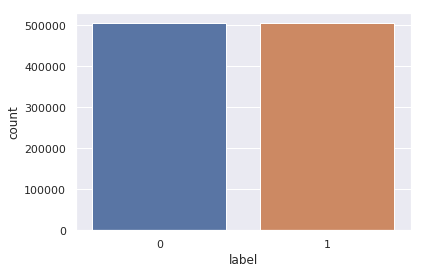

In [21]:
sns.countplot(train_df['label'])

In [22]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

## Frequent Words

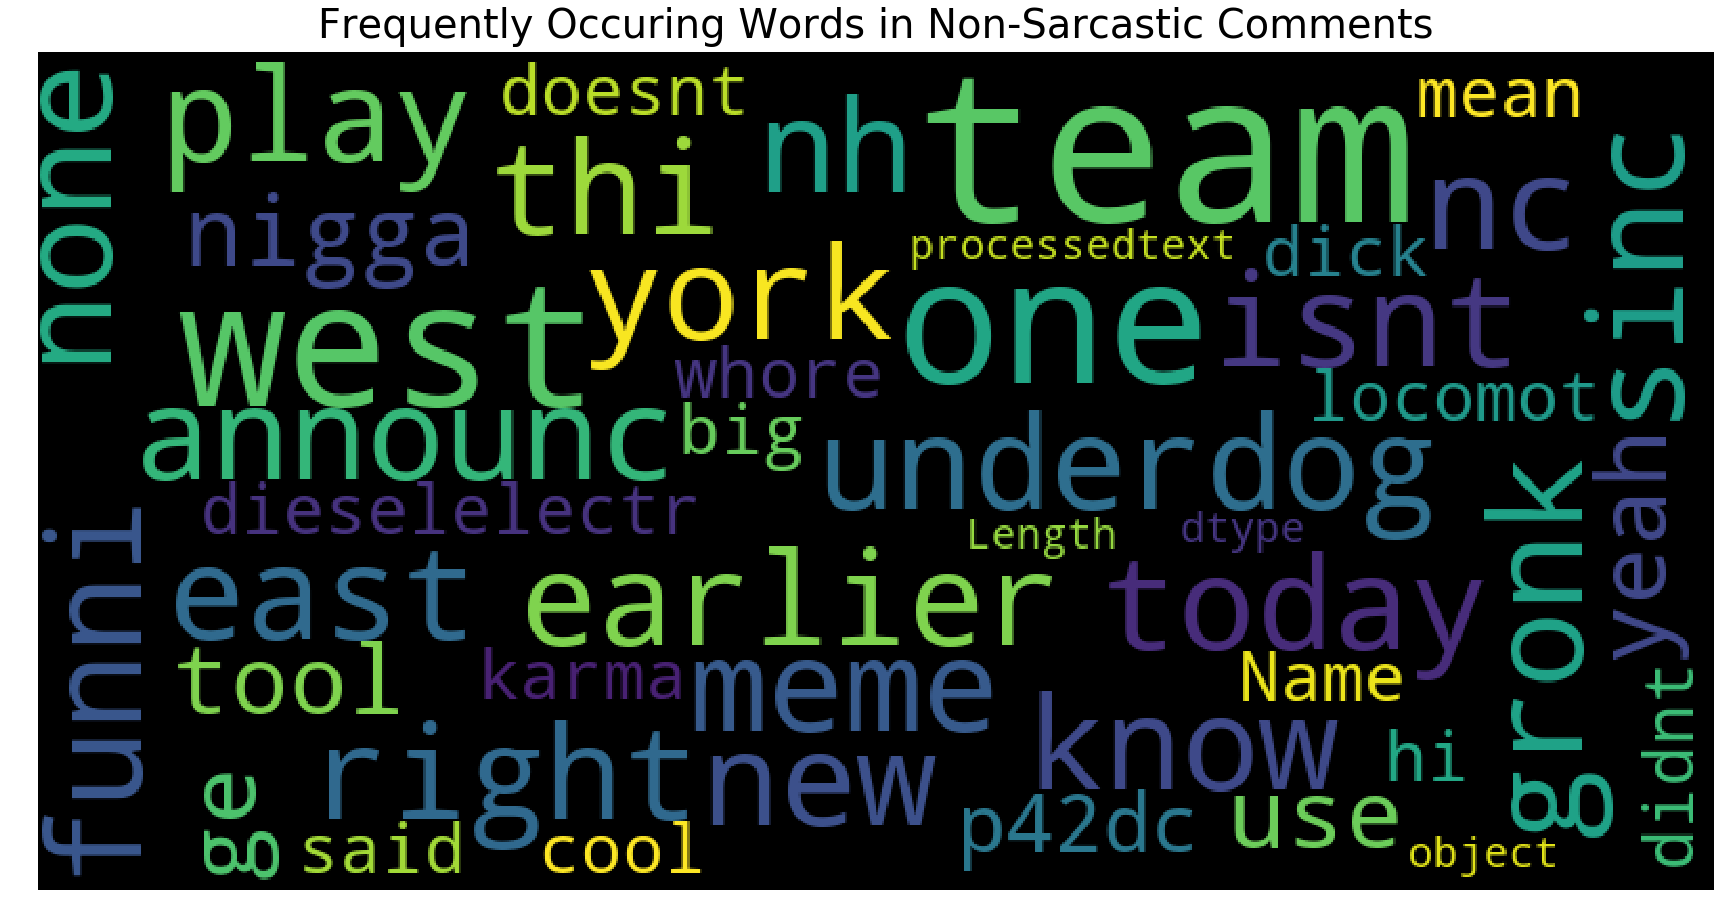

In [23]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color='black',
                    stopwords = STOPWORDS,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df.loc[train_df['label'] == 0, 'processedtext'], title="Frequently Occuring Words in Non-Sarcastic Comments")

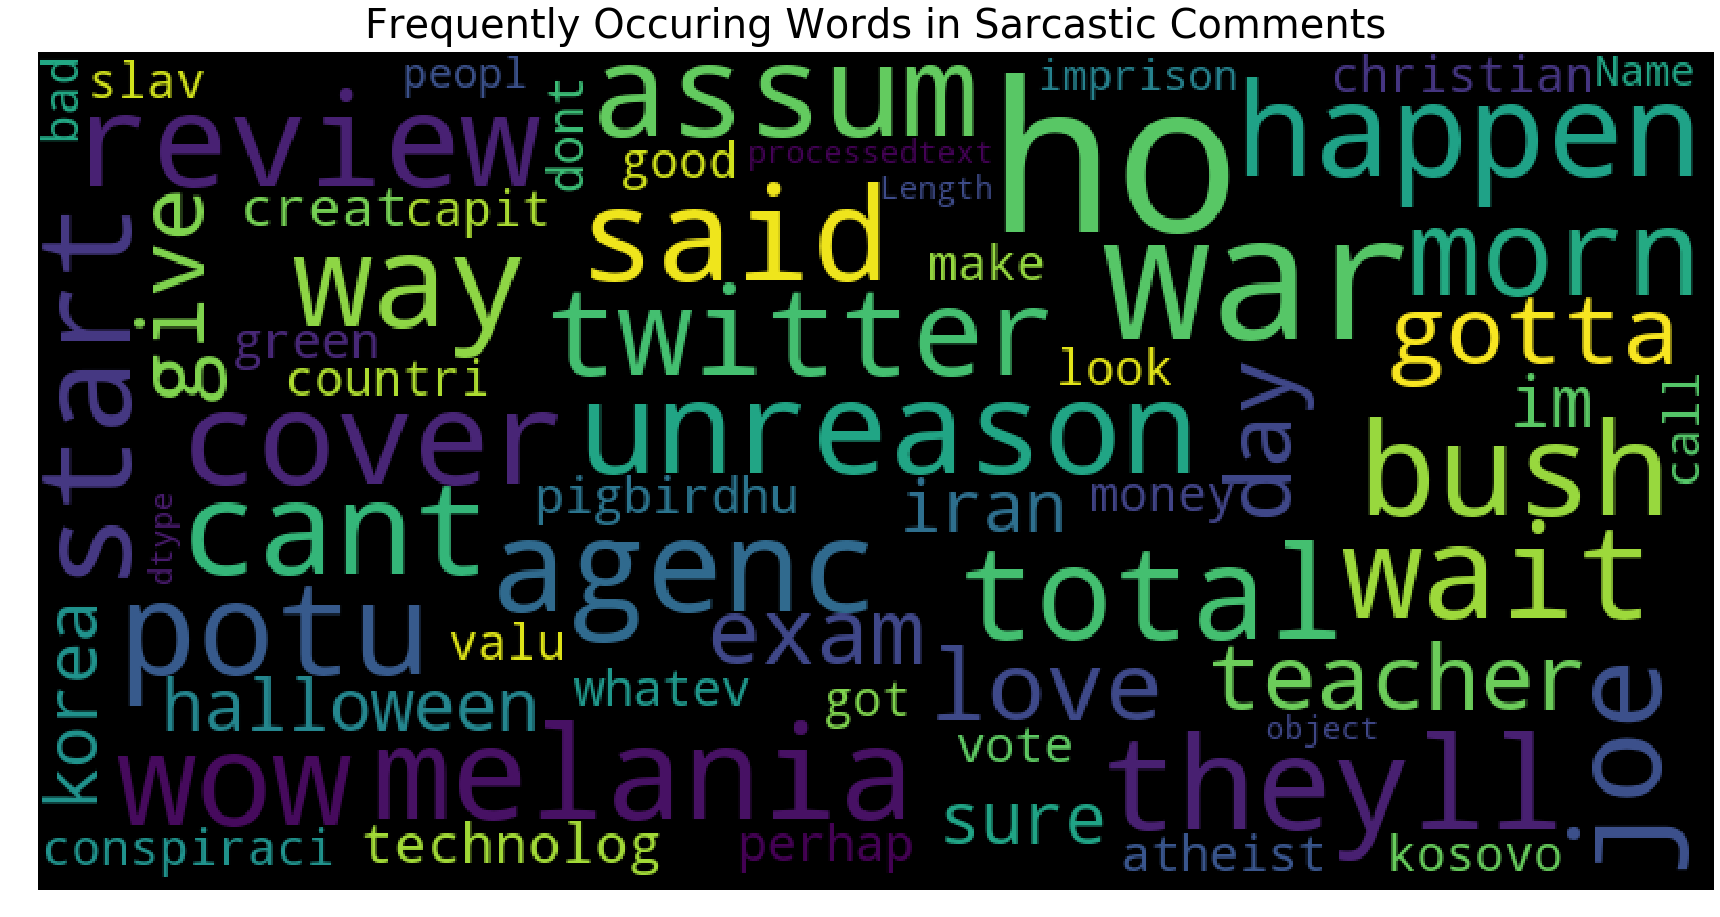

In [24]:
plot_wordcloud(train_df.loc[train_df['label'] == 1, 'processedtext'], title="Frequently Occuring Words in Sarcastic Comments")

In [26]:
from collections import defaultdict
train1_df = train_df[train_df['label'] == 1].dropna()
train0_df = train_df[train_df['label'] == 0].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from non-sarcastic example##
freq_dict = defaultdict(int)
for sent in train0_df['processedtext']:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from sarcastic example##
freq_dict = defaultdict(int)
for sent in train1_df['processedtext']:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of non-sarcastic comments", 
                                          "Frequent words of sarcastic comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

In [27]:
freq_dict = defaultdict(int)
for sent in train0_df['processedtext']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df['processedtext']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of non-sarcastic comment", 
                                          "Frequent bigrams of sarcastic comment"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

In [34]:
freq_dict = defaultdict(int)
for sent in train0_df['comment']:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df['comment']:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of non-sarcastic comment", 
                                          "Frequent trigrams of sarcastic comment"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

## Most Sarcastic Subreddits

In [40]:
subreddit = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])\
            .sort_values(by = 'sum' , ascending = False)
subreddit.head(20)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


## Training Model

In [30]:
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=17, verbose=1)

tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [31]:
%%time
tfidf_logit_pipeline.fit(text_train, y_train)
valid_pred = tfidf_logit_pipeline.predict(text_test)
accuracy_score(y_test, valid_pred)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   39.5s finished


CPU times: user 34.5 s, sys: 832 ms, total: 35.4 s
Wall time: 1min 20s


0.704100611807166

## Model Explanation

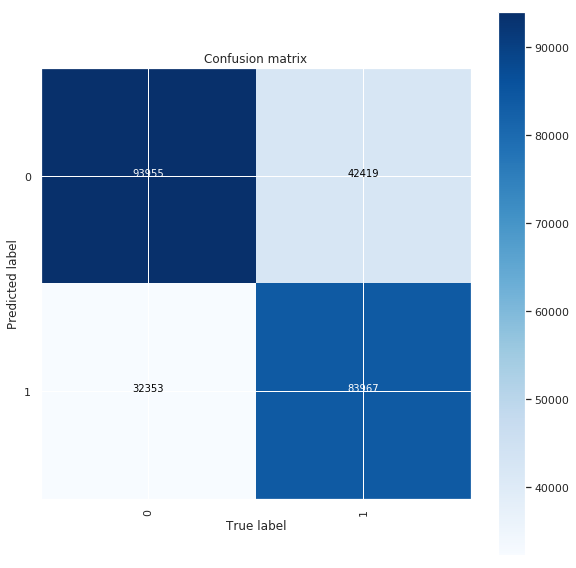

In [32]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')
        
plot_confusion_matrix(y_test, valid_pred, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

In [33]:
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'], top=100 , feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+7.066,obvious
+6.604,clearli
+6.012,but
+5.398,total
+5.154,im sure
+4.955,bbut
+4.918,duh
+4.883,becaus
+4.863,bbbut
+4.809,yeah
